# Cycles of gaps
At every stage of Eratosthenes sieve there is a cycle of gaps $\mathcal{G}(p^\#)$ between the $p$-rough numbers.  The cycle $\mathcal{G}(p^\#)$ has length $\phi(p^\#)$ gaps of span $p^\#$.  

The cycle $\mathcal{G}(p^\#)$ is symmetric: $g_{\phi(p^\#)-i} = g_i$, and $g_{\phi(p^\#)}=2$.



In [1]:
import pandas as pd
import numpy as np
import array
import gc
import psutil
import sys
import os
from pathlib import Path

## Small cycles of gaps
Here we create the first few cycles of gaps.  

Since memory will become a critical limitation we work with unsigned 16-bit integers.

In [2]:
G5 = np.array([6,4,2,4,2,4,6,2], dtype=np.uint16)

In [3]:
G7 = np.array([10,2,4,2,4,6,2,6,4,2,4,6,6,2,6,4,2,6,4,6,8,4,2,4,2,4,8,6,4,6,2,4,6,2,6,6,4,2,4,6,2,6,4,2,4,2,10,2], dtype=np.uint16)
len(G7)

48

There is a 3-step recursion that creates
the next cycle of gaps from the current one.
$$\mathcal{G}(p_{k}^\#) \longrightarrow \mathcal{G}(p_{k+1}^\#)$$

R1. The next prime $p_{k+1}= g_1 +1$.

R2. Concatenate $p_{k+1}$ copies of $\mathcal{G}(p_k^\#)$

R3. *Fusions.* The first fusion is $g_1+g_2$.  Then fuse at the running sums indicated by the elementwise product 
$p_{k+1}\ast \mathcal{G}(p_k^\#)$.

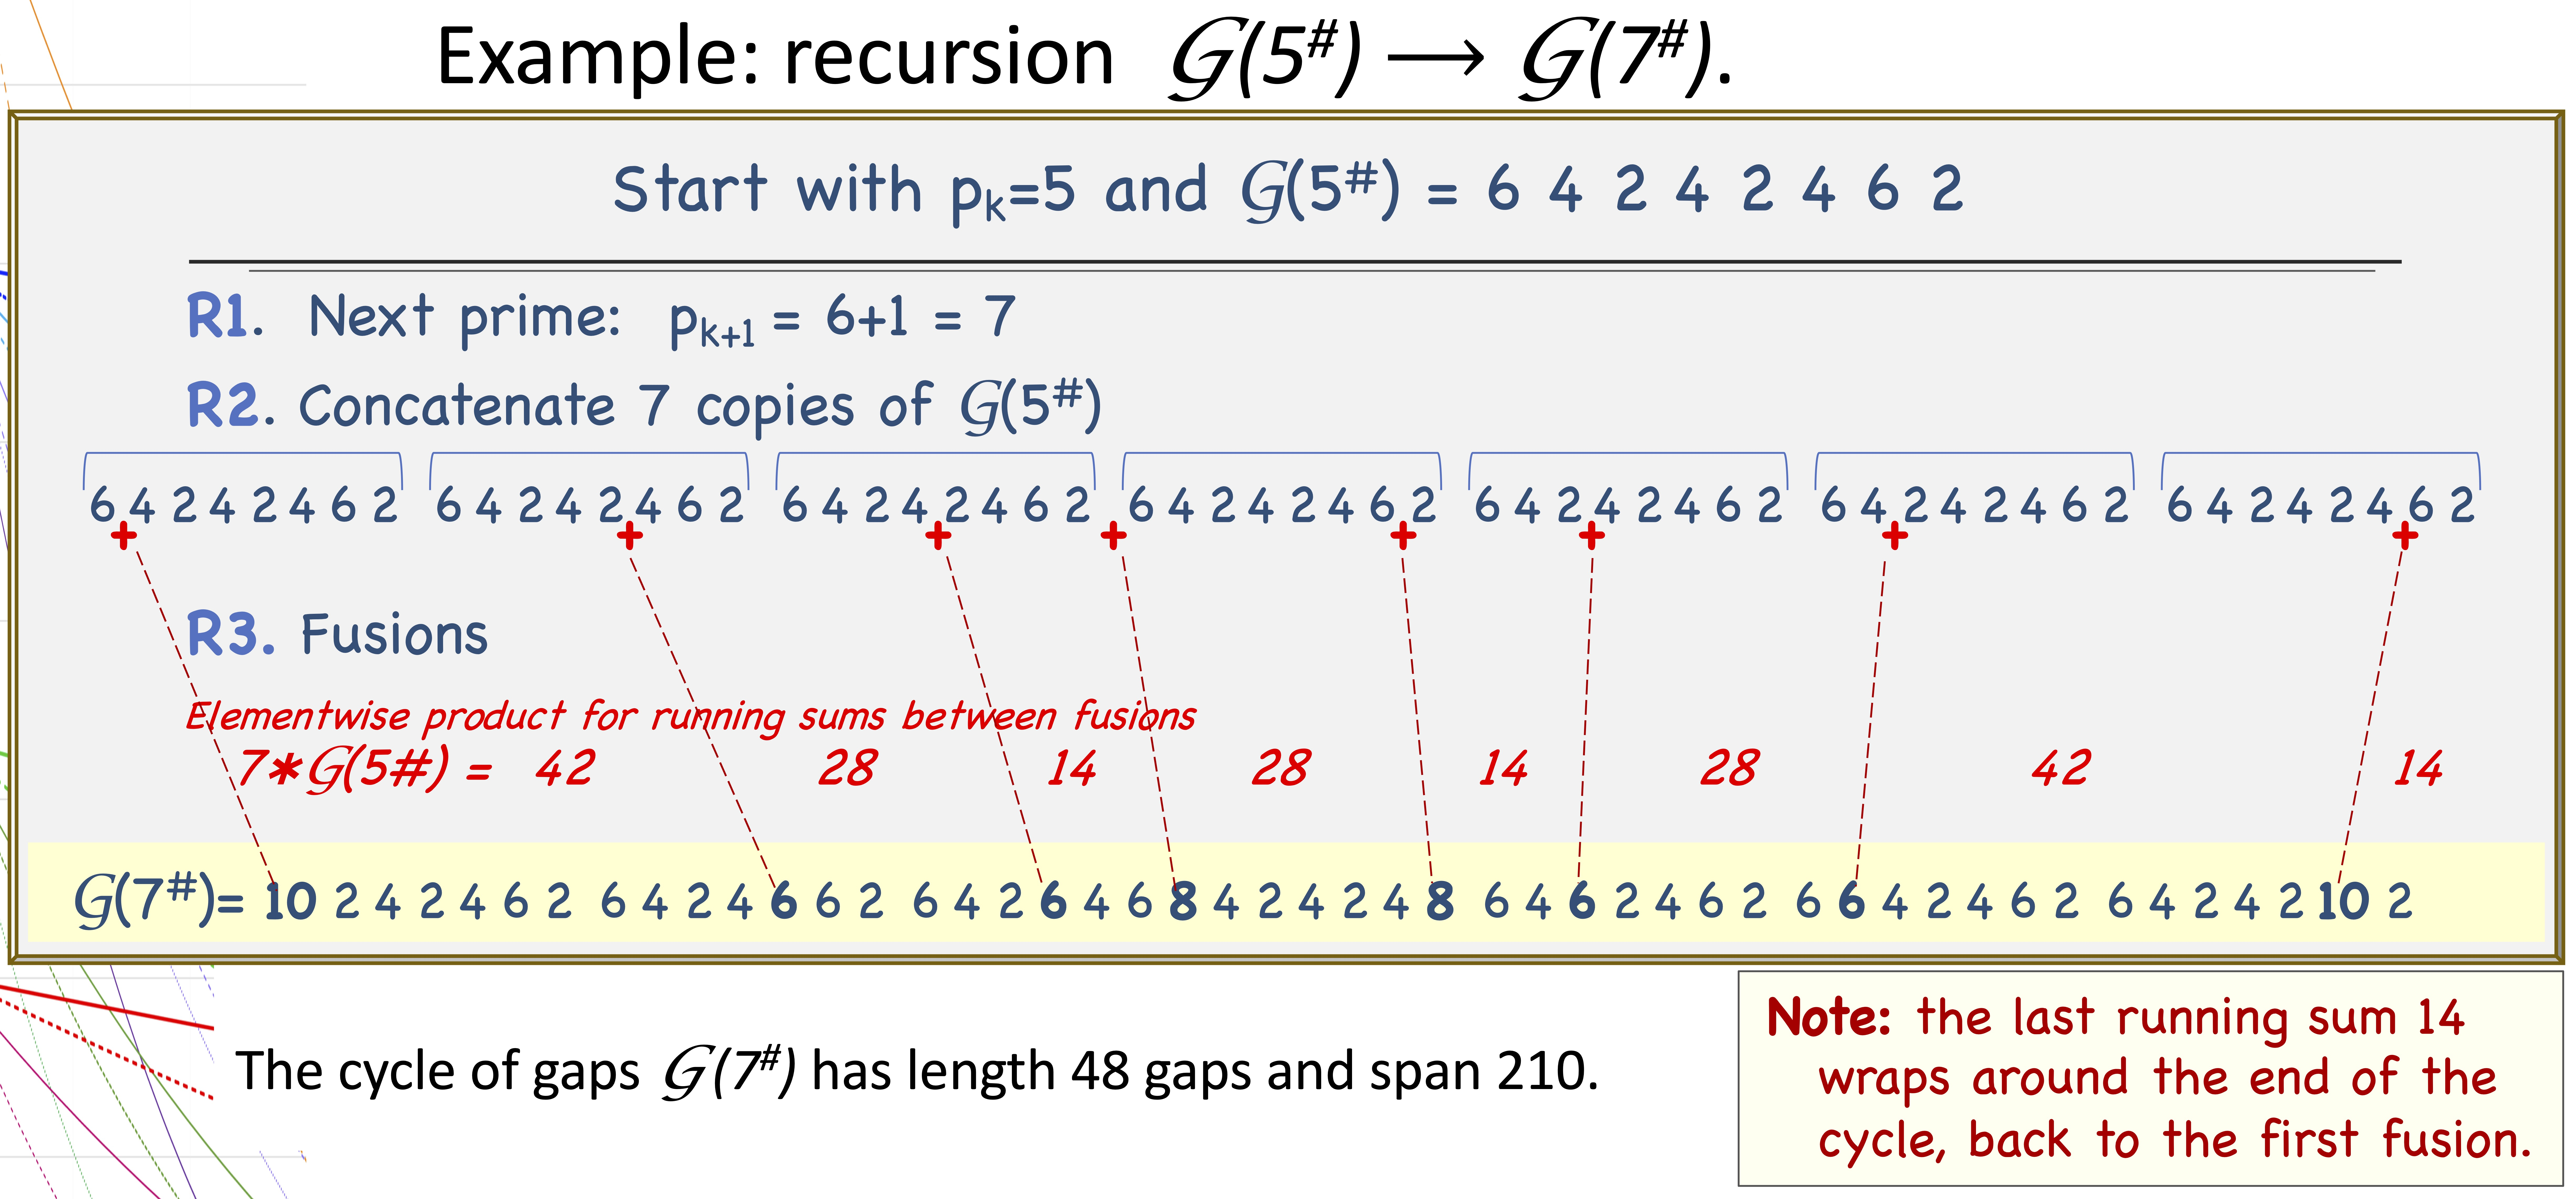

In [4]:
def R123(Gin):
    """
    Performs the 3-step recursion on a cycle G(p#). 
    Returns the next cycle of gaps.
    """
    gc.collect()
    newp = Gin[0]+1
    lenG = (newp -1) * len(Gin)
    lenGin = len(Gin)
    print("length ", lenG, "for cycle G(",newp ,"#)")
    try:
        Gout = array.array('H', [0]*lenG)
    except MemoryError:
        print("Memory allocation fail in R123 for p=", newp)
        Gout = array.array('H', [0]*4)
        return Gout
    """
    We will use Gin and a counter to track the concatentations in R2
    """
    icopy = 1  # index for the concatenated copy of Gin
    ifusion = 0  # index for the running sums newp*Gin
    Gout[0] = Gin[0]
    iin = 0  # index for copying from Gin
    iout = 0  # index for copying into Gout
    while (iout < (lenG-1)):  # This loop starts at a fusion
        targetsum = newp * Gin[ifusion]
        iin += 1
        if (iin >= lenGin):  # move into the next copy of Gin
                iin = 0
                icopy += 1
        runningsum = Gin[iin]
        Gout[iout] += Gin[iin]
        while (runningsum < targetsum and iout < (lenG-1) ):
            iin += 1
            iout += 1
            if (iin >= lenGin):  # move into the next copy of Gin
                iin = 0
                icopy += 1
            runningsum += Gin[iin]  # add to the running sum
            Gout[iout] = Gin[iin]   # copy into the new cycle
        # this point marks the next fusion
        if (runningsum > targetsum):
            print("sum error at fusion", ifusion, runningsum, "vs", targetsum)
        if (ifusion < (lenGin -1)):
            ifusion += 1
    return(Gout)

Notice that the recursion is memoryless.  As we move forward from $\mathcal{G}(p_{k}^\#)$ to $\mathcal{G}(p_{k+1}^\#)$, the recursion does not remember the value of $p_k$.  The gaps and primes from $1$ up to $p_{k+1}$ are aggregated together into the first gap $g_1$ in $\mathcal{G}(p_k^\#)$.

The first gap $g_1$ in $\mathcal{G}(p_k)$ goes from $1$ to $p_{k+1}$, passing over the confirmed primes.

In [5]:
G11 = R123(G7)

length  480 for cycle G( 11 #)


In [6]:
nG11 = np.unique(G11, return_counts=True)

In [7]:
nG11

(array([ 2,  4,  6,  8, 10, 12, 14], dtype=uint16),
 array([135, 135, 142,  28,  30,   8,   2]))

In [8]:
G13 = R123(G11)

length  5760 for cycle G( 13 #)


In [9]:
nG13 = np.unique(G13, return_counts=True)

In [10]:
nG13

(array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 22], dtype=uint16),
 array([1485, 1485, 1690,  394,  438,  188,   58,   12,    8,    2]))

In [11]:
G17=R123(G13)

length  92160 for cycle G( 17 #)


In [12]:
nG17 = np.unique(G17, return_counts=True)

In [13]:
G19 = R123(G17)

length  1658880 for cycle G( 19 #)


In [14]:
nG19 = np.unique(G19, return_counts=True)

In [15]:
G23 = R123(G19)

length  36495360 for cycle G( 23 #)


In [16]:
nG23 = np.unique(G23, return_counts=True)

In [24]:
if os.path.isfile('G29uint.npy'):
    G29 = np.load('G29uint.npy')
else:
    G29 = R123(G23)
    np.save('G29uint.npy', G29)

In [18]:
nG29 = np.unique(G29, return_counts=True)

On my laptop, I trip the MemoryError on $\mathcal{G}(31^\#)$.

This is near the limit of the cycles that we can create completely and explicitly.  A colleague Helgi Rudd calculated $\mathcal{G}(37^\#)$.
The length of the cycle grows superexponentially by factors of $(p-1)$.


In [19]:
memory = psutil.virtual_memory()
available_memory = memory.available
print(f"Available memory: {available_memory / (1024 ** 2):.2f} MB")

Available memory: 3107.75 MB


In [20]:
print(f"G29 is {sys.getsizeof(G29)/(1024**2) :.3f} MB")

G29 is 1949.063 MB


From here we have three forks to our development:
- develop relative population models $w_s(p^\#)$ for gaps and constellations for cycles far beyond what we can explicitly construct
- close G29 or shifted images to obtain gaps among primes, for statistical comparisons to the models
- exploring models for survival to create estimates from the $w_s(p^\#)$, for those statistical comparisons.

The best first-order model for survival to-date (2024) is to assume uniform distribution of the gaps or constellations in the interval of survival $\Delta H(p_k) = [p_k^2, p_{k+1}^2]$.

In [21]:
G29[0:20]

array('H', [30, 6, 4, 2, 4, 6, 6, 2, 6, 4, 2, 6, 4, 6, 8, 4, 2, 4, 2, 4])